In [2]:
# Third-party
import astropy.coordinates as coord
from astropy.io import ascii, fits
from astropy.table import Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
from pyia import GaiaData

import gala.dynamics as gd
import gala.potential as gp
from gala.mpl_style import center_deemph, center_emph

In [3]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)
mw = gp.MilkyWayPotential()

In [3]:
# t1 = Table.read('/Users/adrian/data/APOGEE_DR16/allStar-r12-l33.fits')
# # t1 = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
# t2 = Table.read('/Users/adrian/data/APOGEE_DR15beta/APOGEE_preDR15_SH_release_Feb2019.fits')
# t3 = Table.read('/Users/adrian/data/APOGEE_DR16/apogeedr16-result.fits')

In [4]:
# gaia_match = t1['APOGEE_ID', 'RA', 'DEC']
# gaia_match.write('/Users/adrian/data/APOGEE_DR16/apogee_gaia_match.csv', overwrite=True)
# len(gaia_match)

In [68]:
# apogee_ids, counts = np.unique(t3['apogee_id'], return_counts=True)
# keep_apogee_ids = apogee_ids[counts == 1]
# t3 = t3[np.isin(t3['apogee_id'], keep_apogee_ids)]
# t3['APOGEE_ID'] = t3['apogee_id']

In [69]:
# t = join(t1, t3, keys='APOGEE_ID')
# t = join(t, t2, keys='APOGEE_ID')
# t = t[t['SH_OUTPUTFLAGS'] == '']
# len(t)

274663

Remove cluster and dSph targeted stars:

In [71]:
# apogee_target1 = [9, 18, 26]
# apogee_target2 = [13, 17, 18]

# # TODO: 19 here is "possible stream member"
# apogee2_target1 = [9, 18, 20, 21, 22, 23, 26]
# apogee2_target2 = []
# apogee2_target3 = [5, 14, 15]

# targ_mask = (t['APOGEE_TARGET1'] & np.sum(2**np.array(apogee_target1))) == 0
# targ_mask &= (t['APOGEE_TARGET2'] & np.sum(2**np.array(apogee_target2))) == 0
# targ_mask &= (t['APOGEE2_TARGET1'] & np.sum(2**np.array(apogee2_target1))) == 0
# # targ_mask &= (t['APOGEE2_TARGET2'] & np.sum(2**np.array(apogee2_target2))) == 0
# targ_mask &= (t['APOGEE2_TARGET3'] & np.sum(2**np.array(apogee2_target3))) == 0
# targ_mask.sum()

In [73]:
# mask = ((t['TEFF'] > 3000) & (t['TEFF'] < 6500) & 
#         (t['parallax'] < 1.) & 
#         (t['M_H'] < -0.5) & (t['M_H'] > -3) & 
#         (np.abs(t['VHELIO_AVG']) < 500))
# mask.sum()

In [75]:
# glob = Table.read('/Users/adrian/data/Misc/Harris-globclust.fits')
# gals = ascii.read('/Users/adrian/data/Misc/NearbyGalaxies.dat')

# glob_c = coord.SkyCoord(ra=glob['ra'], dec=glob['dec'], unit=(u.hourangle, u.degree))
# gals_c = coord.SkyCoord(ra=gals['RA'], dec=gals['Dec'], unit=(u.hourangle, u.degree))
# known_c = coord.concatenate((glob_c, gals_c))
# known_names = np.concatenate((np.array(glob['name']), np.array(gals['name'])))

In [77]:
# g = GaiaData(t[mask & targ_mask])
# print(len(g))

# g_c = g.get_skycoord(distance=False,
#                      radial_velocity=g.VHELIO_AVG*u.km/u.s)
# mean_idx, mean_sep, _ = g_c.match_to_catalog_sky(known_c)

# known_mask = mean_sep > 1*u.deg
# g = g[known_mask]
# g.data.write('starhorse-halo-r12.fits', overwrite=True)
# g_c = g.get_skycoord(distance=g.dist50*u.kpc,
#                      radial_velocity=g.VHELIO_AVG*u.km/u.s)
# len(g)

26163


23974

In [4]:
g = GaiaData('starhorse-halo-r12.fits')
g = g[g.M_H < -1]
g_c = g.get_skycoord(distance=g.dist50*u.kpc,
                     radial_velocity=g.VHELIO_AVG*u.km/u.s)

In [5]:
n_samples = 256
samples = g.get_error_samples(size=n_samples)

_dist = np.random.normal(g.dist50, g.dist84-g.dist50, size=(n_samples, len(g))).T * u.kpc
_dist[_dist <= 0] = np.nan*u.kpc
c_samples = samples.get_skycoord(distance=_dist,
                                 radial_velocity=np.random.normal(g.VHELIO_AVG, g.VSCATTER, size=(n_samples, len(g))).T * u.km/u.s)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [6]:
# g_samples = g[samples_mask]
g_samples = g

galcen = c_samples.transform_to(galcen_frame)
# d25_mask = np.median(np.sqrt(np.sum(galcen.data.xyz**2, axis=0)), axis=1) > 5*u.kpc

# NOTE: mask
w0 = gd.PhaseSpacePosition(g_c.transform_to(galcen_frame).data) # [d25_mask]
w0_samples = gd.PhaseSpacePosition(galcen.data) # [d25_mask]
# g_samples = g_samples[d25_mask]
w0.shape, w0_samples.shape

((3662,), (3662, 256))

In [7]:
orbits = mw.integrate_orbit(w0, dt=2, n_steps=512)

In [8]:
apo = orbits.apocenter(approximate=True)
peri = orbits.pericenter(approximate=True)
ecc = orbits.eccentricity(approximate=True)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
L = w0_samples.angular_momentum().to_value(u.km/u.s*u.kpc)
Lxy = np.sqrt(L[0]**2 + L[1]**2)
Lz = -L[2]

E = w0_samples.energy(gp.Hamiltonian(mw)).to_value((u.km/u.s)**2) / 1e5

med_E = np.median(E, axis=1)
med_Lz = np.median(Lz, axis=1)
med_Lxy = np.median(Lxy, axis=1)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 11 results
  r = func(a, **kwargs)


In [10]:
# Lz_lim = (-900, 900)
# Lxy_lim = (0, 50)
# E_lim = (-0.18, -0.03)

Lz_lim = (-3500, 3500)
Lxy_lim = (0, 50)
# E_lim = (-0.16, -0.05)
E_lim = (-2, 0)

In [11]:
gd1_w0 = gd.PhaseSpacePosition(pos=[3.08883067, -13.90147025, 3.52704602]*u.kpc,
                               vel=[0.20228031, 0.06519415, -0.17736016]*u.kpc/u.Myr)
gd1_Lz = -gd1_w0.angular_momentum()[2].to_value(u.km/u.s*u.kpc)
gd1_E = gd1_w0.energy(gp.Hamiltonian(mw)).to_value((u.km/u.s)**2) / 1e5

Text(0,0.5,'$\\sqrt{L_{xy}}$')

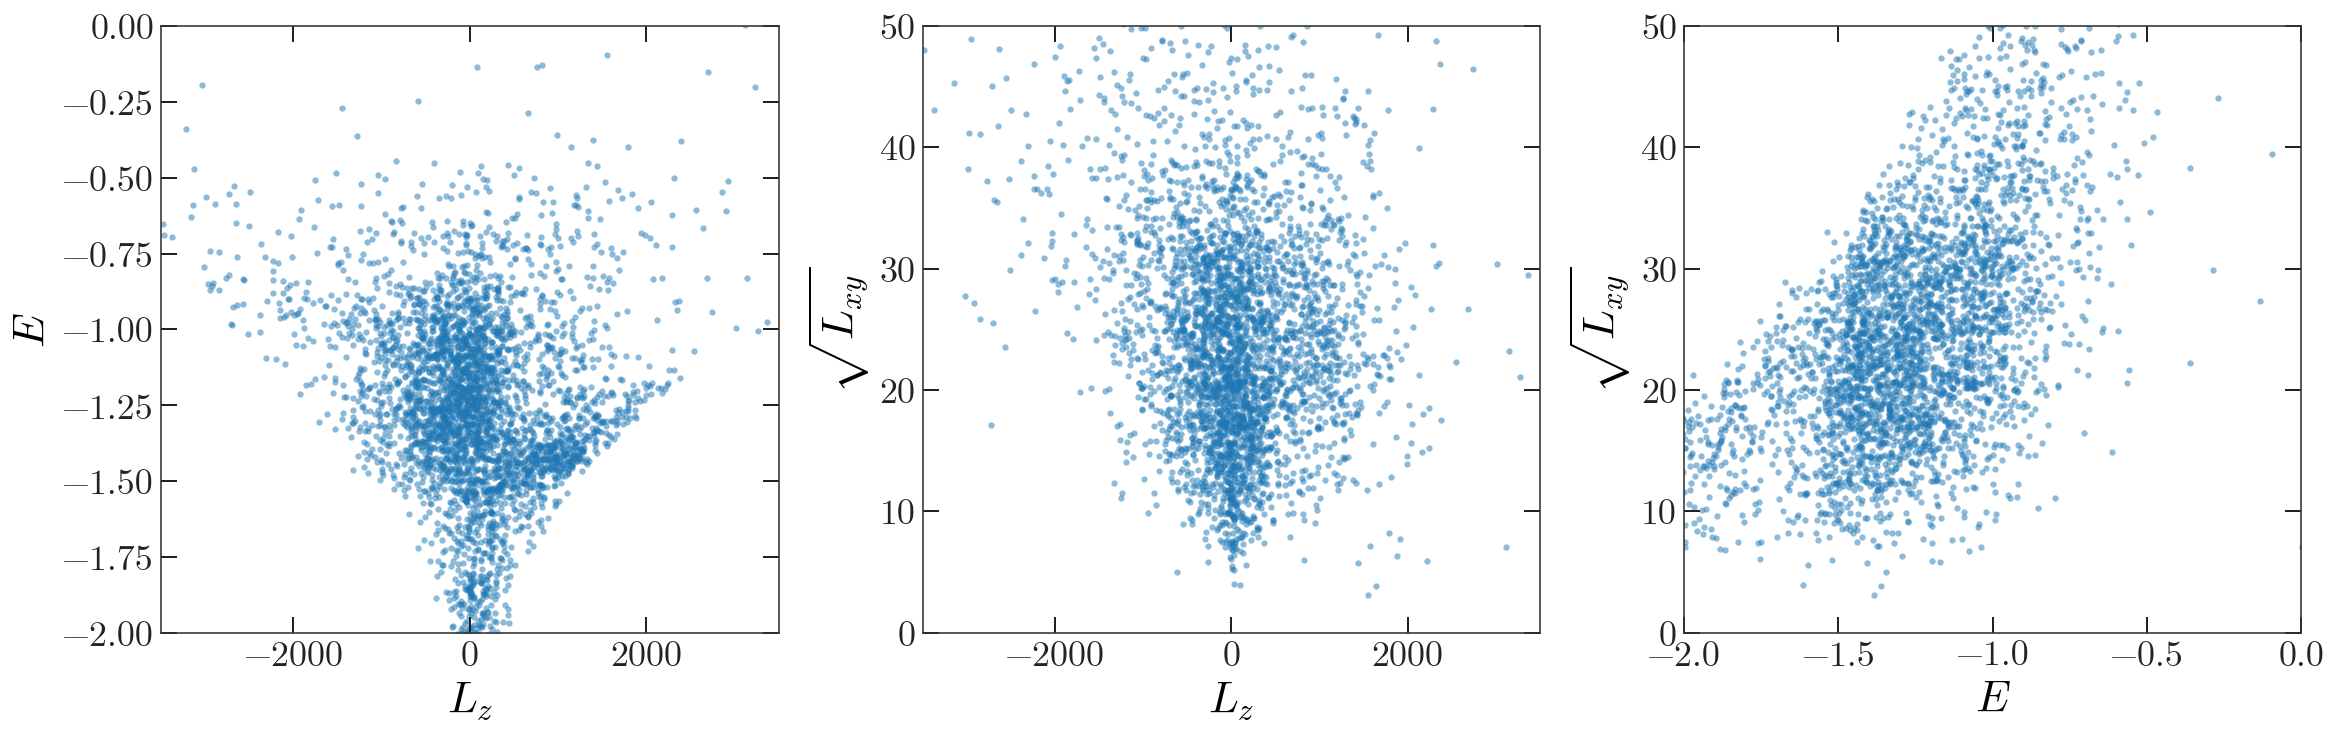

In [23]:
style = dict(marker='o', 
             alpha=0.5, s=10,
             vmin=-2, vmax=-0.8,
             cmap='hesperia', 
             lw=0, edgecolor='k')

fig, axes = plt.subplots(1, 3, figsize=(16, 5),
                         constrained_layout=True)

ax = axes[0]
ax.scatter(med_Lz, med_E, **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(E_lim)
ax.set_xlabel('$L_z$')
ax.set_ylabel('$E$')

# ax.scatter(gd1_Lz, gd1_E, color='tab:red', s=50)

ax = axes[1]
ax.scatter(med_Lz, np.sqrt(med_Lxy), **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(Lxy_lim)
ax.set_xlabel('$L_z$')
ax.set_ylabel('$\sqrt{L_{xy}}$')

ax = axes[2]
im = ax.scatter(med_E, np.sqrt(med_Lxy), **style)
ax.set_xlim(E_lim)
ax.set_ylim(Lxy_lim)
ax.set_xlabel('$E$')
ax.set_ylabel('$\sqrt{L_{xy}}$')

(0, 1)

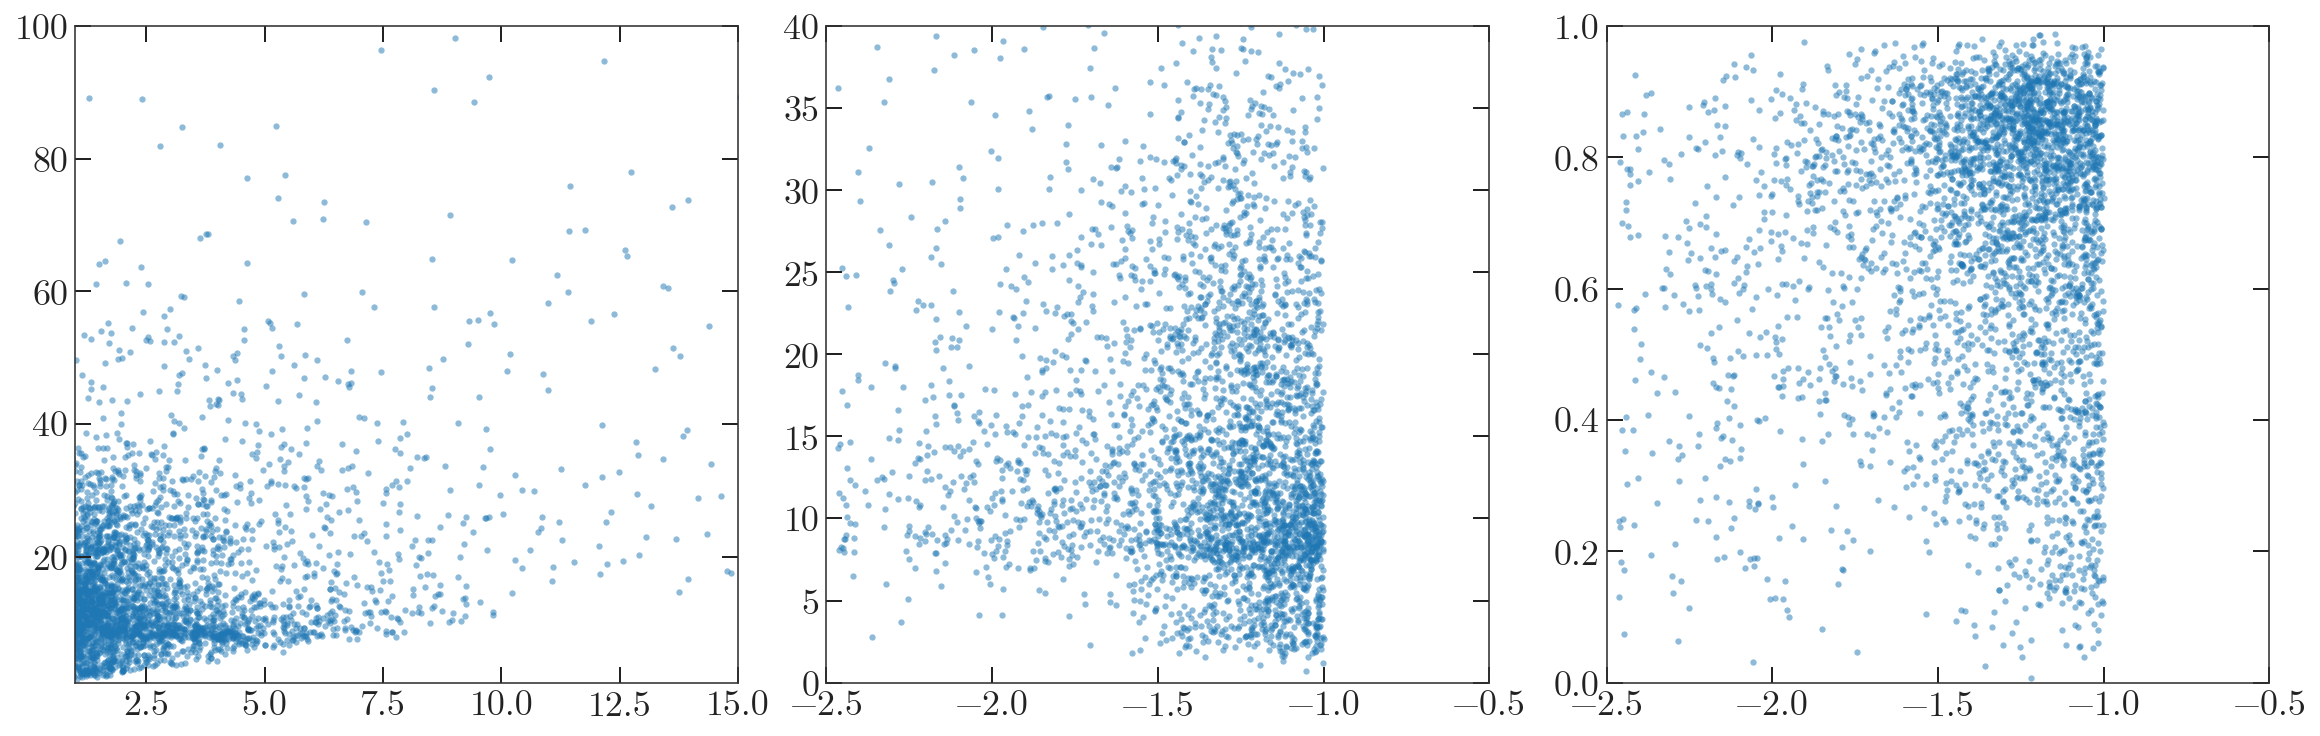

In [13]:
style = dict(marker='o', 
             alpha=0.5, s=10,
             vmin=-2, vmax=-0.8,
             cmap='hesperia', 
             lw=0, edgecolor='k')

fig, axes = plt.subplots(1, 3, figsize=(16, 5),
                         constrained_layout=True)

ax = axes[0]
ax.scatter(peri, apo, **style)
ax.set_xlim(1, 15)
ax.set_ylim(1, 100)

# ax.scatter(gd1_Lz, gd1_E, color='tab:red', s=50)

ax = axes[1]
ax.scatter(g.M_H, apo, **style)
ax.set_xlim(-2.5, -0.5)
ax.set_ylim(0, 40)
# ax.set_xlabel('$L_z$')
# ax.set_ylabel('$\sqrt{L_{xy}}$')

ax = axes[2]
ax.scatter(g.M_H, ecc, **style)
ax.set_xlim(-2.5, -0.5)
ax.set_ylim(0, 1)

In [19]:
# clump_mask = ((med_E > -1.6) & (med_E < -1.35) & 
#               (med_Lz > 350) & (med_Lz < 1200) &
#               (g_samples.M_H < -1.5))# & 

# Prograde clump
clump_mask = ((med_Lxy < 10**2) &
              (med_Lz > 1000) & (med_Lz < 2500))

# Sequoia
# clump_mask = ((med_Lz > -3000) & (med_Lz < -1000) & 
#               (med_E < -0.8) & (med_E > -1.1))

sausage_mask = ((med_Lz < 500) & (med_Lz > -500) & 
                (med_E < -0.8) & (med_E > -1.4))

clump_mask.sum(), sausage_mask.sum()

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


(8, 1267)

Text(0,0.5,'$\\sqrt{L_{xy}}$')

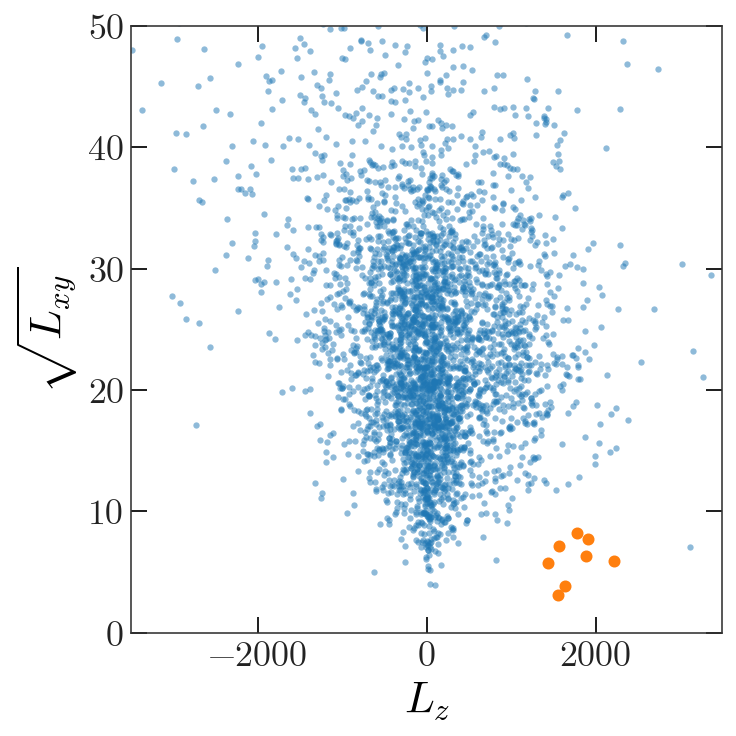

In [22]:
style = dict(marker='o', 
             alpha=0.5, s=10,
             vmin=-2, vmax=-0.8,
             cmap='Spectral', 
             lw=0, edgecolor='k')

fig, ax = plt.subplots(1, 1, figsize=(5, 5),
                       constrained_layout=True)

ax.scatter(med_Lz, np.sqrt(med_Lxy), **style)
ax.scatter(med_Lz[clump_mask], np.sqrt(med_Lxy)[clump_mask])
# ax.scatter(med_Lz[sausage_mask], np.sqrt(med_Lxy)[sausage_mask])
ax.set_xlim(Lz_lim)
ax.set_ylim(Lxy_lim)
ax.set_xlabel('$L_z$')
ax.set_ylabel(r'$\sqrt{L_{xy}}$')

# ax.scatter(gd1_Lz, gd1_E, color='tab:red', s=50)

Text(0,0.5,'[$\\alpha/{\\rm Fe}$]')

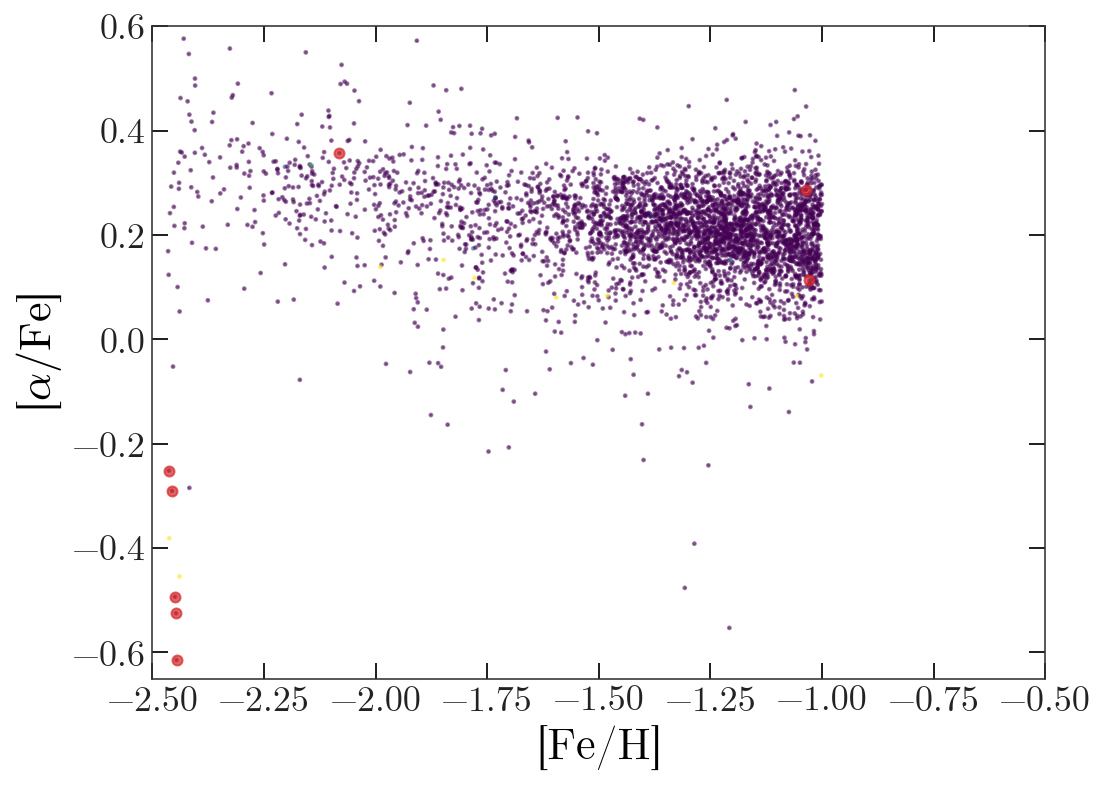

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(g.M_H, g.ALPHA_M,
           c=med_E, marker='o', alpha=0.5, s=2,
           vmin=-0.18, vmax=-0.05)

im = ax.scatter(g[clump_mask].M_H, 
                g[clump_mask].ALPHA_M,
                color='tab:red', alpha=0.7)

ax.set_ylim(-0.65, 0.6)
ax.set_xlim(-2.5, -0.5)

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'[$\alpha/{\rm Fe}$]')

(0, 1)

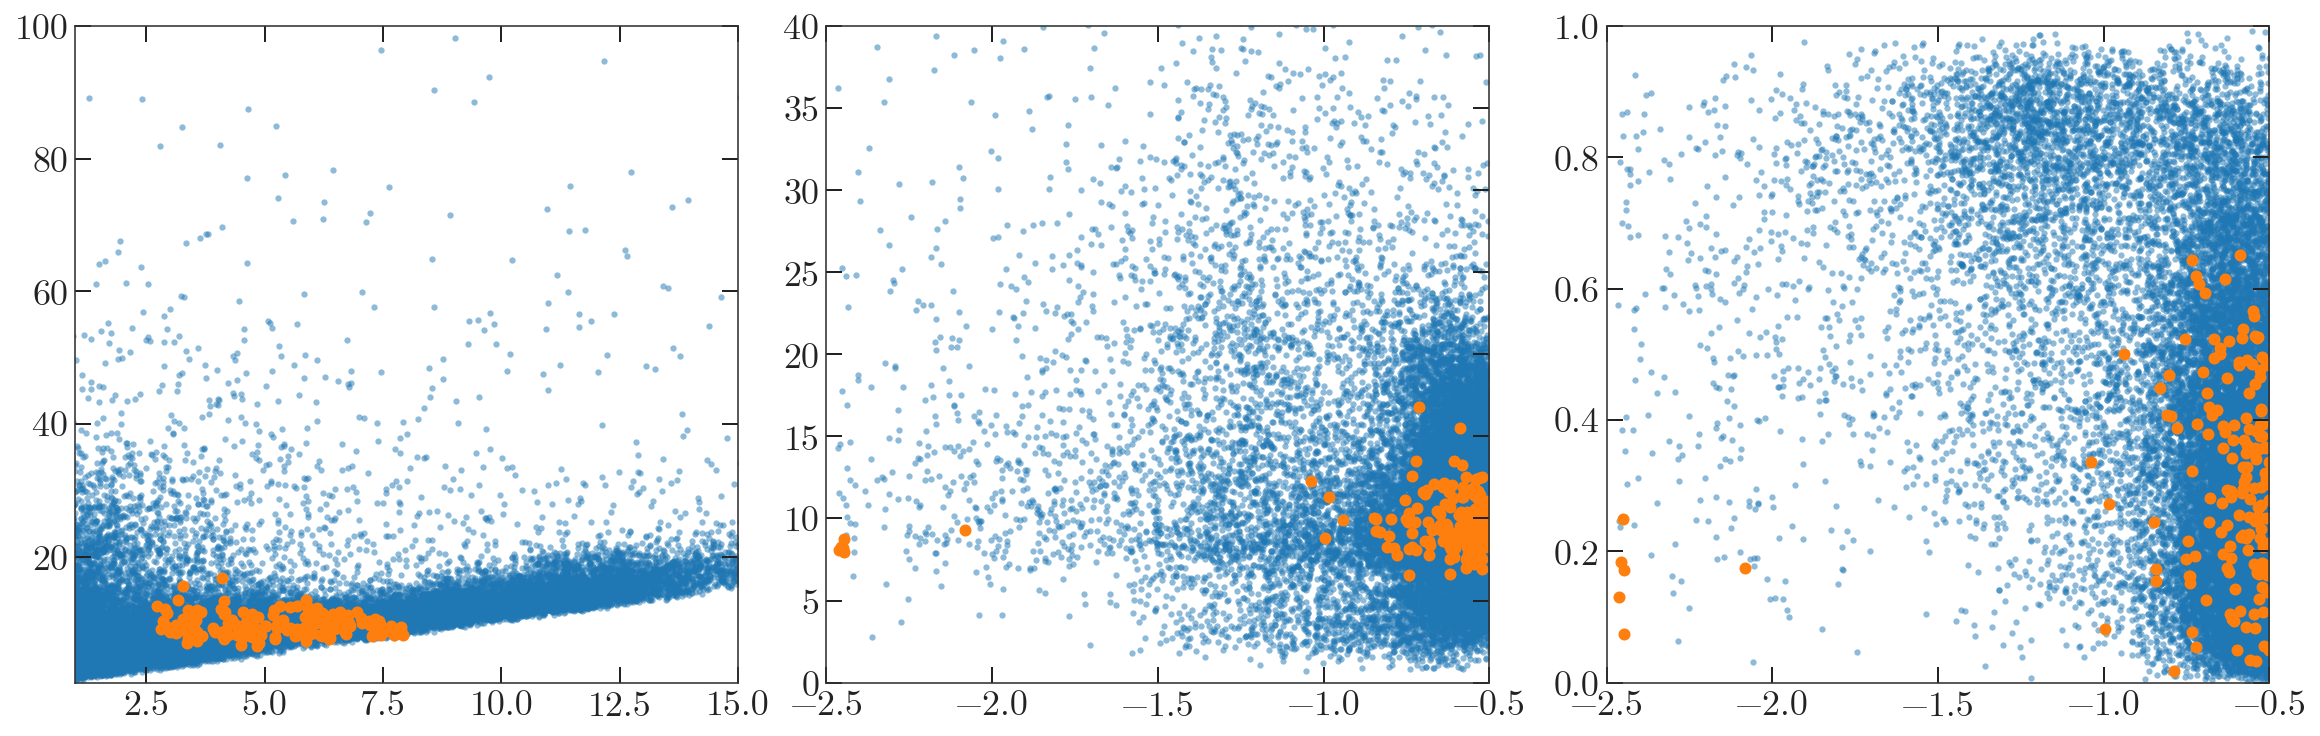

In [17]:
style = dict(marker='o', 
             alpha=0.5, s=10,
             vmin=-2, vmax=-0.8,
             cmap='hesperia', 
             lw=0, edgecolor='k')

fig, axes = plt.subplots(1, 3, figsize=(16, 5),
                         constrained_layout=True)

ax = axes[0]
ax.scatter(peri, apo, **style)
ax.scatter(peri[clump_mask], apo[clump_mask])
# ax.scatter(peri[sausage_mask], apo[sausage_mask])
ax.set_xlim(1, 15)
ax.set_ylim(1, 100)

# ax.scatter(gd1_Lz, gd1_E, color='tab:red', s=50)

ax = axes[1]
ax.scatter(g.M_H, apo, **style)
ax.scatter(g.M_H[clump_mask], apo[clump_mask])
# ax.scatter(g.M_H[sausage_mask], apo[sausage_mask])
ax.set_xlim(-2.5, -0.5)
ax.set_ylim(0, 40)
# ax.set_xlabel('$L_z$')
# ax.set_ylabel('$\sqrt{L_{xy}}$')

ax = axes[2]
ax.scatter(g.M_H, ecc, **style)
ax.scatter(g.M_H[clump_mask], ecc[clump_mask])
# ax.scatter(g.M_H[sausage_mask], ecc[sausage_mask])
ax.set_xlim(-2.5, -0.5)
ax.set_ylim(0, 1)

Text(0,0.5,'[$\\alpha/{\\rm Fe}$]')

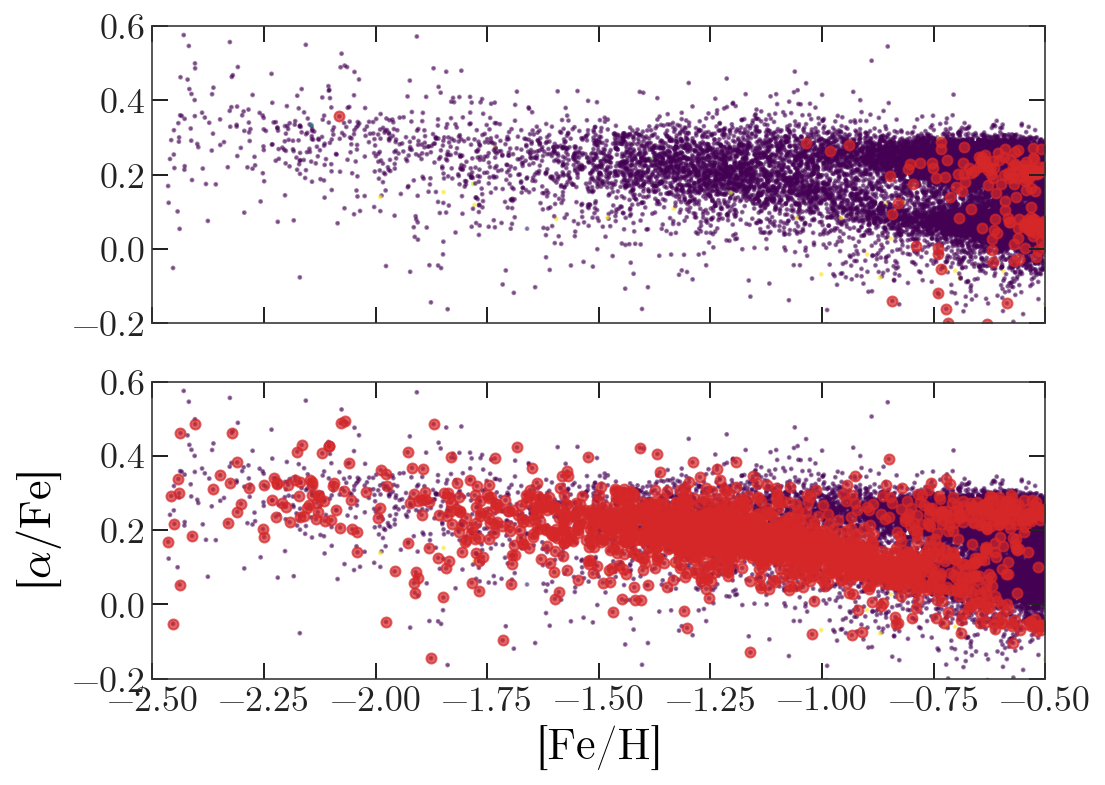

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), 
                         sharex=True, sharey=True)

ax = axes[0]
ax.scatter(g.M_H, g.ALPHA_M,
           c=med_E, marker='o', alpha=0.5, s=2,
           vmin=-0.18, vmax=-0.05)

im = ax.scatter(g[clump_mask].M_H, 
                g[clump_mask].ALPHA_M,
                color='tab:red', alpha=0.7)

ax = axes[1]
ax.scatter(g.M_H, g.ALPHA_M,
           c=med_E, marker='o', alpha=0.5, s=2,
           vmin=-0.18, vmax=-0.05)

im = ax.scatter(g[sausage_mask].M_H, 
                g[sausage_mask].ALPHA_M,
                color='tab:red', alpha=0.7)

ax.set_ylim(-0.2, 0.6)
ax.set_xlim(-2.5, -0.5)

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'[$\alpha/{\rm Fe}$]')

(300, 150)

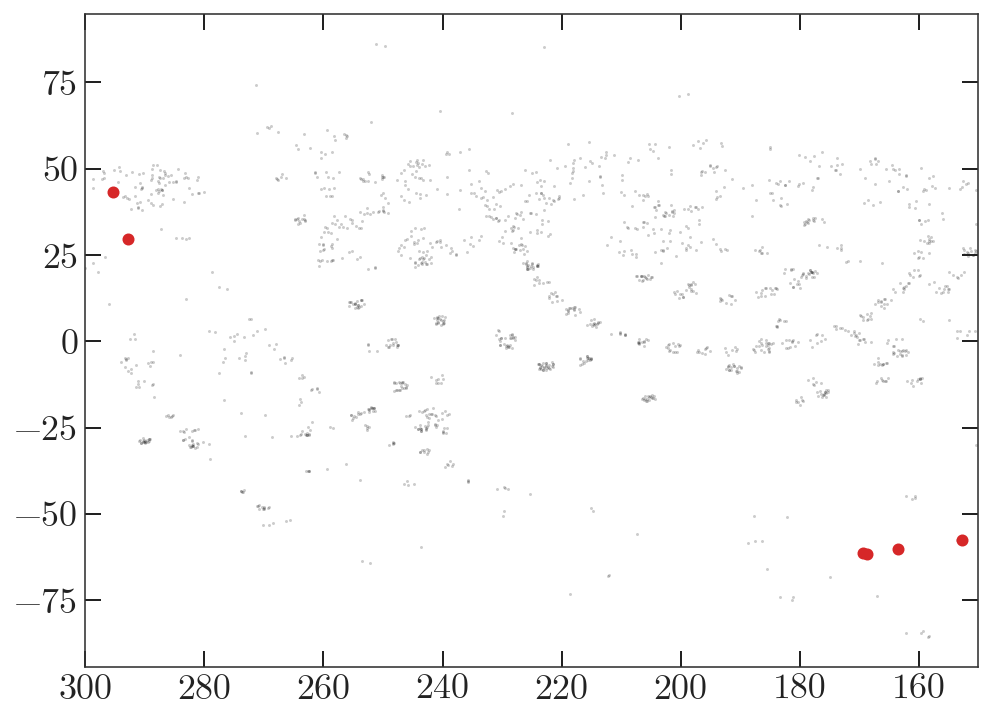

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

im = ax.plot(g.ra, 
             g.dec,
             marker='o', ms=1.5, ls='none', 
             zorder=-100, color='k', alpha=0.2)

# idx = np.random.choice(len(g_samples), size=clump_mask.sum())
# im = ax.scatter(g_samples.ra[idx], 
#                 g_samples.dec[idx],
#                 color='tab:red')

im = ax.scatter(g[clump_mask].ra, 
                g[clump_mask].dec,
                color='tab:red')

ax.set_xlim(300, 150)

# ax.set_xlim(-1, 1)
# ax.set_ylim(-0.1, 0.6)

# ax.set_xlabel('[Fe/H]')
# ax.set_ylabel(r'[$\alpha/{\rm Fe}$]')

Text(0,0.5,'[Al/Fe]')

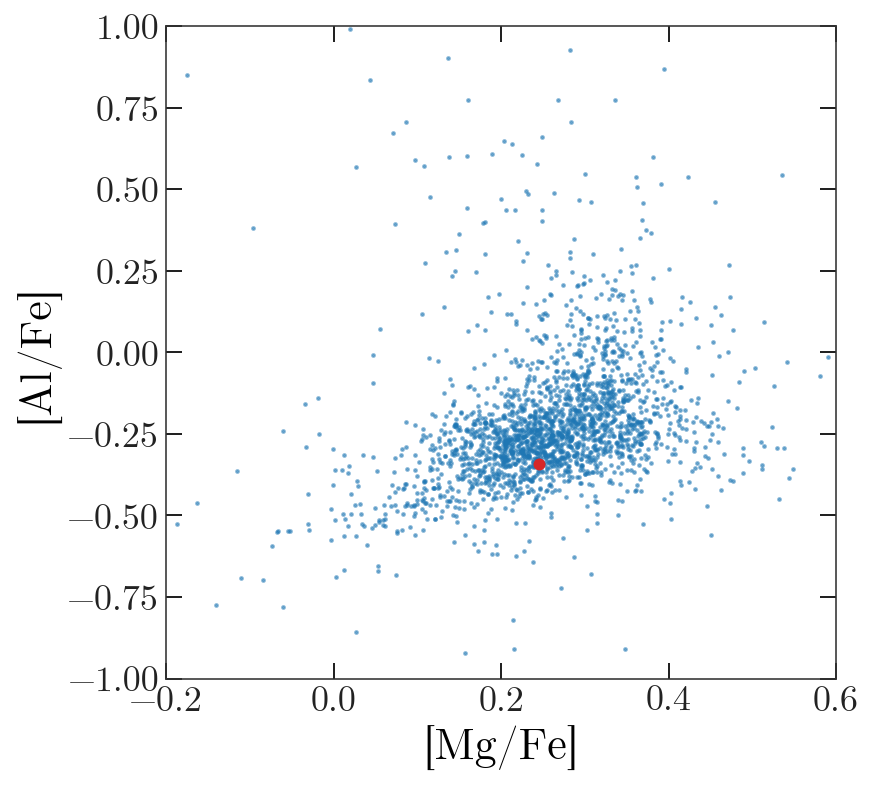

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(g.MG_FE, g.AL_FE,
           marker='o', alpha=0.5, s=2,
           vmin=-0.18, vmax=-0.05)

im = ax.scatter(g[clump_mask].MG_FE, 
                g[clump_mask].AL_FE,
                color='tab:red')

# im = ax.scatter(g_samples[sausage_mask].MG_FE, 
#                 g_samples[sausage_mask].AL_FE,
#                 color='tab:orange')

ax.set_xlim(-0.2, 0.6)
ax.set_ylim(-1, 1)

ax.set_xlabel('[Mg/Fe]')
ax.set_ylabel('[Al/Fe]')

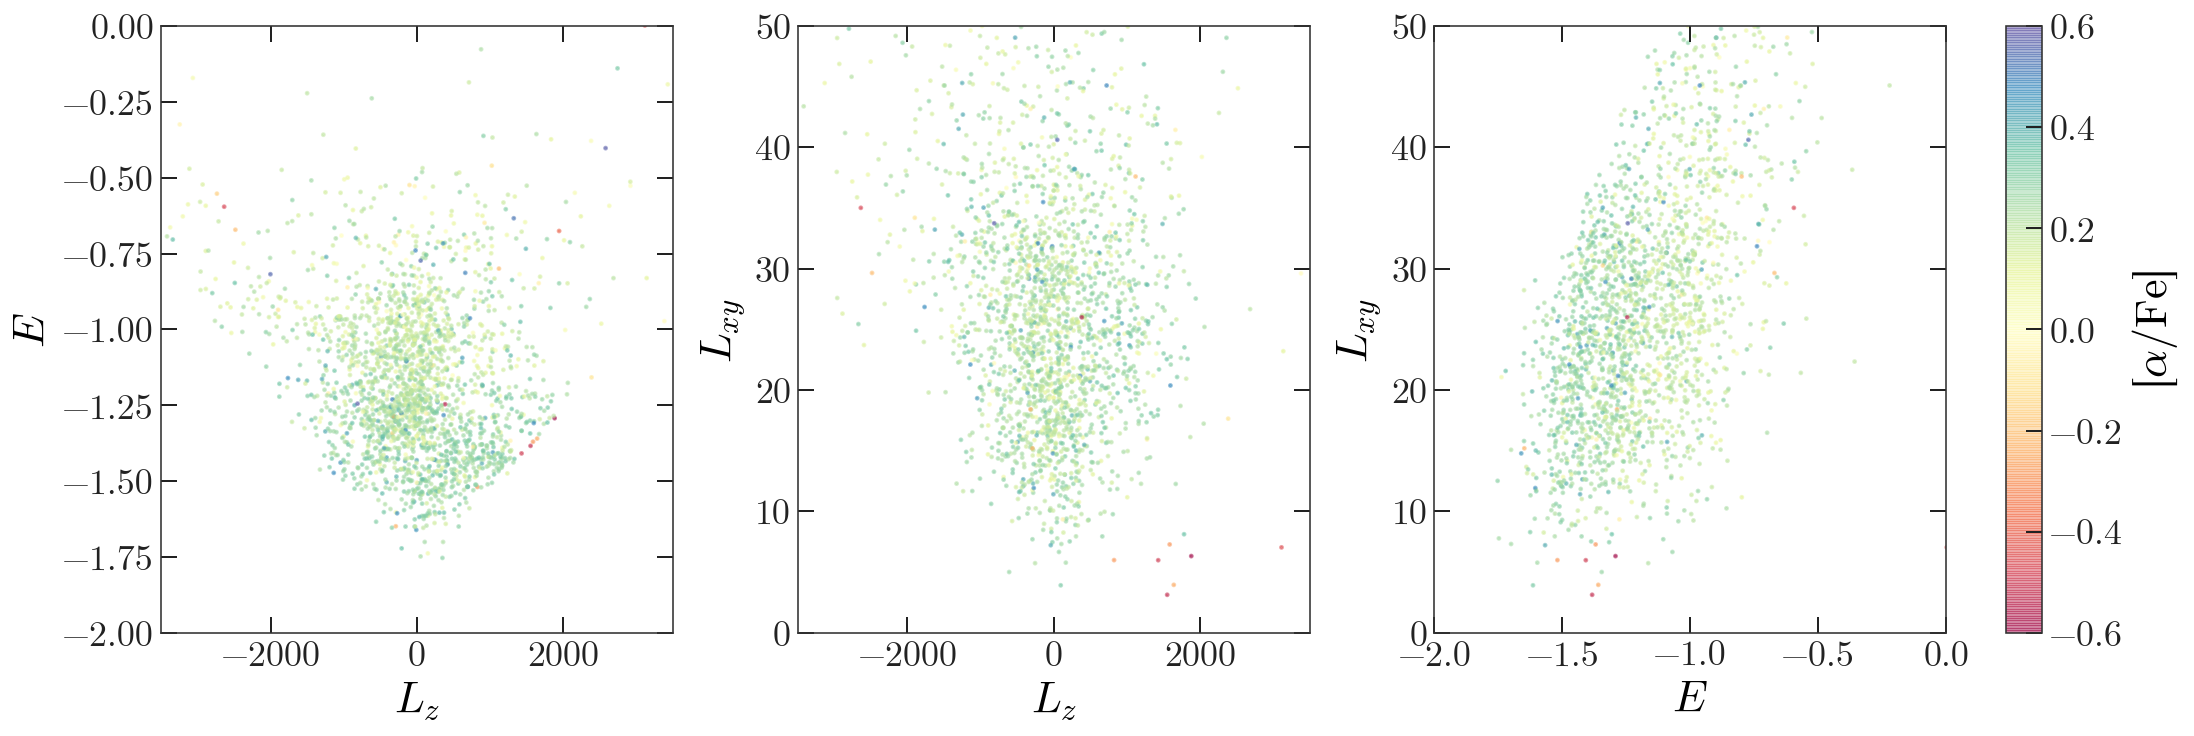

In [97]:
style = dict(marker='o', 
             alpha=0.5, s=2,
             c=g_samples.ALPHA_M, 
             vmin=-0.6, vmax=0.6,
             cmap='Spectral')

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         constrained_layout=True)

ax = axes[0]
ax.scatter(med_Lz, med_E, **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(E_lim)
ax.set_xlabel('$L_z$')
ax.set_ylabel('$E$')

ax = axes[1]
ax.scatter(med_Lz, np.sqrt(med_Lxy), **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(Lxy_lim)
ax.set_xlabel('$L_z$')
ax.set_ylabel('$L_{xy}$')

ax = axes[2]
im = ax.scatter(med_E, np.sqrt(med_Lxy), **style)
ax.set_xlim(E_lim)
ax.set_ylim(Lxy_lim)
ax.set_xlabel('$E$')
ax.set_ylabel('$L_{xy}$')

cb = fig.colorbar(im, ax=axes, aspect=50)
cb.set_label(r'[$\alpha/{\rm Fe}$]')

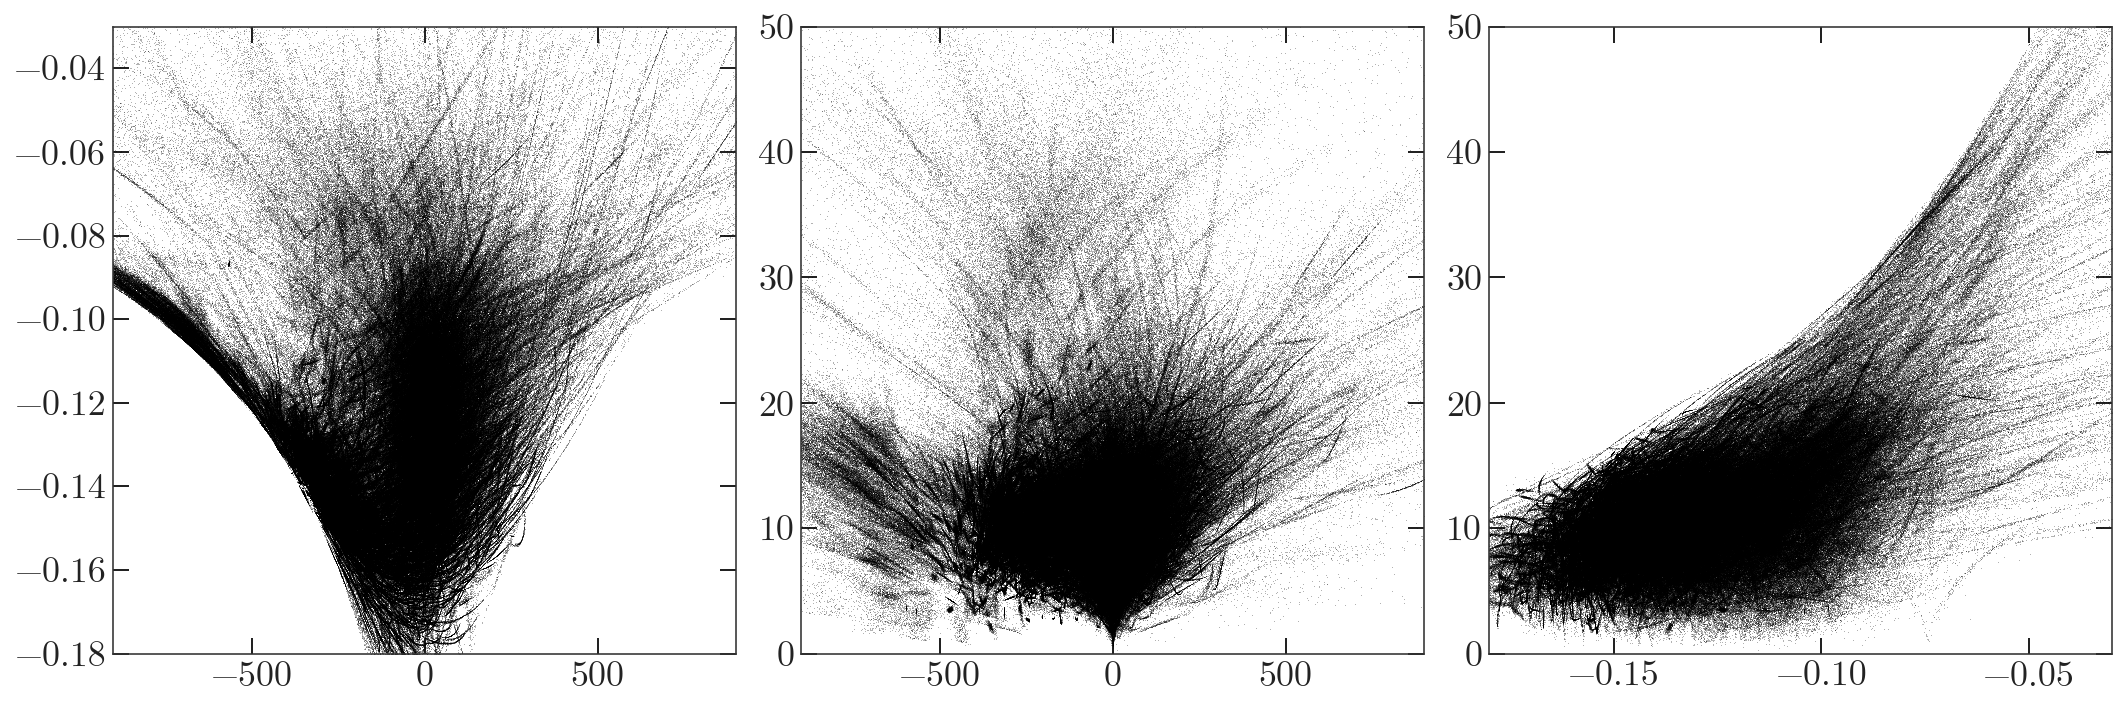

In [27]:
style = dict(marker=',', ls='none', 
             color='k', alpha=0.3, ms=1.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.plot(Lz, E, **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(E_lim)

ax = axes[1]
ax.plot(Lz, np.sqrt(Lxy), **style)
ax.set_xlim(Lz_lim)
ax.set_ylim(Lxy_lim)

ax = axes[2]
ax.plot(E, np.sqrt(Lxy), **style)
ax.set_xlim(E_lim)
ax.set_ylim(Lxy_lim)

fig.tight_layout()